In [1]:
import os

# IMPORTANT: Replace with your actual Twitch application credentials
os.environ["TWITCH_CLIENT_ID"] = "pgapguj2m5e5mm637jg1sx952kjdzw"
os.environ["TWITCH_CLIENT_SECRET"] = "du7gazte4165jh8rn8w4pao37zpazi"

print("TWITCH_CLIENT_ID and TWITCH_CLIENT_SECRET environment variables set.")

TWITCH_CLIENT_ID and TWITCH_CLIENT_SECRET environment variables set.


In [2]:
import pandas as pd
import os
from pathlib import Path

# Find the latest games CSV file in the 'igdb_csv' directory
outdir = Path("igdb_csv")
if outdir.exists():
	try:
		latest_games_file = sorted(outdir.glob("games_*.csv"), reverse=True)[0]
		print(f"Loading data from: {latest_games_file}")
		df = pd.read_csv(latest_games_file)
		print(df.head())  # show first 5 rows
	except IndexError:
		print("No games CSV file found in 'igdb_csv' directory.")
		print("Please run the data download cell first.")
else:
	print("'igdb_csv' directory not found.")
	print("Please run the data download cell first to create it.")

Loading data from: igdb_csv/games_20251015_1657.csv
   id  aggregated_rating aggregated_rating_count first_release_date   genres  \
0   1          90.000000                     1.0          953596800  5|13|31   
1   2          70.000000                     1.0          912384000    13|31   
2   3          83.000000                     2.0         1085443200  5|13|31   
3   4          63.642857                    14.0         1393286400     5|31   
4   5                NaN                     NaN          914198400       12   

                      name        platforms                    slug  \
0  Thief II: The Metal Age                6  thief-ii-the-metal-age   
1  Thief: The Dark Project                6  thief-the-dark-project   
2    Thief: Deadly Shadows             11|6    thief-deadly-shadows   
3                    Thief  9|48|6|14|12|49                   thief   
4            Baldur's Gate        3|6|39|14           baldur-s-gate   

   total_rating  total_rating_count    u

In [5]:
import pandas as pd
from pathlib import Path
import numpy as np

# Adjust timestamp to your generated CSVs
ts = "20251015_1600"  
outdir = Path("igdb_csv")

games = pd.read_csv(outdir / f"games_20251001_1633.csv")
popularity_primitives = pd.read_csv(outdir / f"popularity_primitives_20251015_1657.csv")
popularity_types = pd.read_csv(outdir / f"popularity_types_20251001_1809.csv")

# Adding game_time_to_beats to explore top games based on playtime weighted popularity score
game_time_to_beats = pd.read_csv(outdir / f"game_time_to_beats_20251015_1657.csv")

In [6]:
# Exploratory Idea #2: Analyze top 10 video games based on playtime weighted popularity score
# What are the most popular video games based on player engagement; Looking into how long people play specific video games for

In [10]:
# STEP 1: Load merged popularity and game info from 'Game_Popularity' notebook
# Unnecessary to merge and clean columns again from same csv file merge

popularity_with_games = pd.read_csv("igdb_popularity_by_game.csv")

In [13]:
# STEP 2: Merge 'popularity_with_games' with playtime data
# Merge on game_id (linking time-to-beat and popularity)
playtime_popularity = popularity_with_games.merge(
    game_time_to_beats[["game_id", "normally", "hastily", "completely"]],
    on="game_id",
    how="left"
)

In [34]:
# STEP 3: Clean column names
playtime_popularity = playtime_popularity.rename(columns={
    "name_y": "game_name",
    "name_x": "popularity_type_name"
})

In [35]:
# STEP 4: Compute average playtime
playtime_popularity["avg_playtime"] = playtime_popularity[
    ["normally", "hastily", "completely"]
].mean(axis=1, skipna=True)

In [36]:
# Compute playtime-based popularity score
# Combine popularity value with engagement
playtime_popularity["playtime_popularity"] = (
    playtime_popularity["value"] * np.log1p(playtime_popularity["avg_playtime"])
)

In [43]:
# Aggregate data by game
game_popularity_summary = (
    playtime_popularity
    .groupby("game_name", as_index=False)
    .agg({
        "value": "mean",
        "avg_playtime": "mean",
        "playtime_popularity": "mean"
    })
    .sort_values("playtime_popularity", ascending=False)
    .head(10)
)
print(game_popularity_summary)

                        game_name     value  avg_playtime  playtime_popularity
4235               cyberpunk-2077  0.002967  5.762675e+08             0.059859
24                          142.0  0.002338  5.762928e+08             0.047155
5049           grand-theft-auto-v  0.003479  3.340697e+05             0.044245
7492      the-witcher-3-wild-hunt  0.002921  3.261397e+05             0.037076
1861      Minecraft: Java Edition  0.002044  4.135502e+07             0.035840
85                           64.0  0.001097  5.762065e+08             0.022124
2892  The Elder Scrolls V: Skyrim  0.001695  3.933133e+05             0.021837
4737                    fallout-4  0.001078  5.762779e+08             0.021739
58                           29.0  0.001058  5.762067e+08             0.021348
1312  Grand Theft Auto: Vice City  0.001050  5.763642e+08             0.021184


In [39]:
playtime_popularity.to_csv("igdb_playtime_popularity.csv", index=False)
print("✅ Saved merged Game Popularity Engagement dataset.")

✅ Saved merged Game Popularity Engagement dataset.


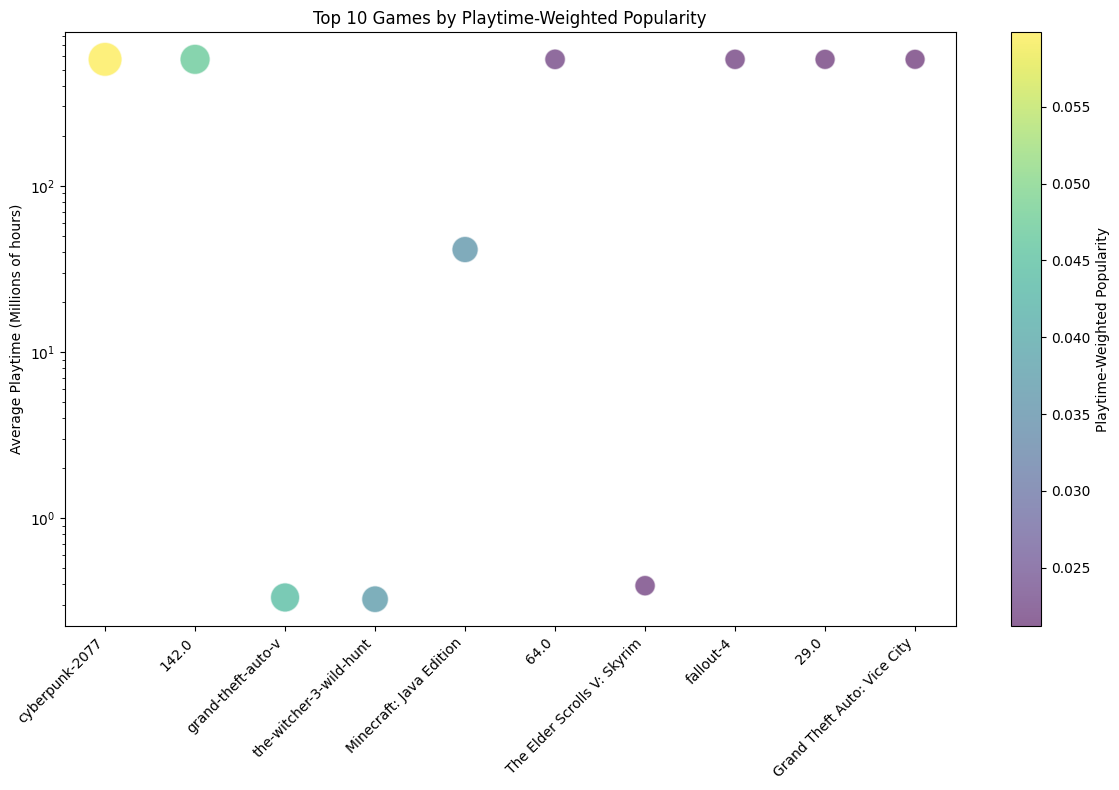

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# Use game_popularity_summary from previous aggregation
df = game_popularity_summary.copy()

plt.figure(figsize=(12,8))

# Rescale avg_playtime and bubble size
df["avg_playtime_million"] = df["avg_playtime"] / 1e6
bubble_sizes = df["playtime_popularity"] * 10000

# Bubble chart: X = game names, Y = avg playtime, size = playtime_popularity
plt.scatter(
    x=np.arange(len(df)),                  # numeric X positions
    y=df["avg_playtime_million"],                  # Y = average playtime
    s=bubble_sizes,        # bubble size proportional to score
    alpha=0.6,
    c=df["playtime_popularity"],           # color by popularity
    cmap="viridis",
    edgecolors="w"
)

# Labeling X-axis with game names
plt.xticks(np.arange(len(df)), df["game_name"], rotation=45, ha="right")
plt.ylabel("Average Playtime (Millions of hours)")
plt.title("Top 10 Games by Playtime-Weighted Popularity")
plt.colorbar(label="Playtime-Weighted Popularity")
plt.tight_layout()
plt.yscale("log")
plt.show()

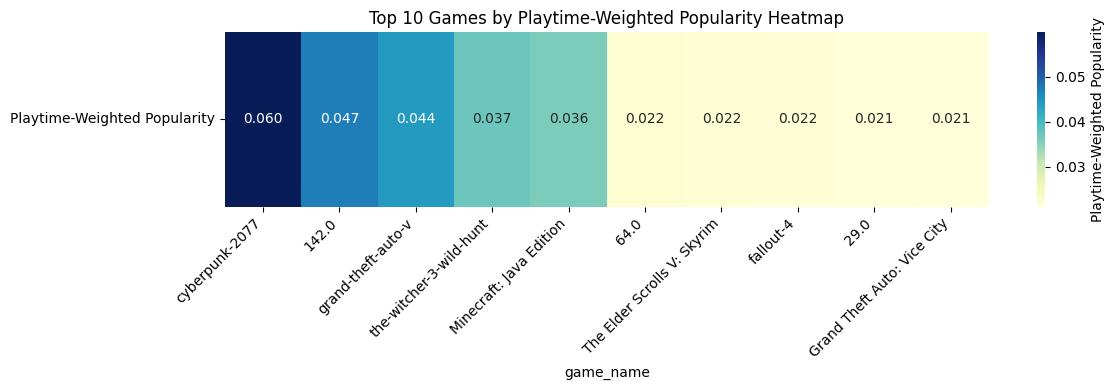

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Copy the top 10 games
df = game_popularity_summary.copy()

# Rescale avg_playtime for heatmap (millions of hours)
df["avg_playtime_million"] = df["avg_playtime"] / 1e6

# Create a pivot table for heatmap
# We'll use game names as columns and a single row of avg_playtime_million
heatmap_data = pd.DataFrame(df["playtime_popularity"].values.reshape(1, -1),
                            columns=df["game_name"],
                            index=["Playtime-Weighted Popularity"])

# Plot heatmap
plt.figure(figsize=(12,4))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".3f",
    cmap="YlGnBu",
    cbar_kws={'label': 'Playtime-Weighted Popularity'}
)
plt.title("Top 10 Games by Playtime-Weighted Popularity Heatmap")
plt.yticks(rotation=0)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()